# Note
--- v2 update ---
- Adotp new data prepare methord
- change to more modulized
- drop pipeline for clear


    
Thanks a lot again, waiting for you reply.
Meng

--- v1 archive ---
- finish local run out. (mac env)
- base line sumbition

(v1)Hi Reviewer,

Thanks for your time to review my capestone project. I want to make some note at top to save your time on review my project.

- structure
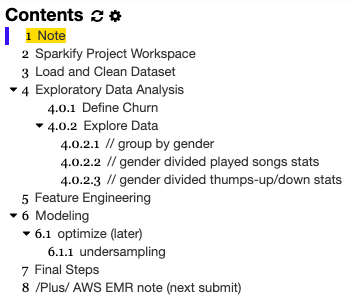

- request for coaching
    - **Q1:How to practice Sprak at real world?** I am new to spark, I manage about 3 week to finish this project, and still get some unclear on part of it. So where can I get some real big data to explore the skill of spark (on AWS, not local). Can you share something?
    - **Q2:Spark vs Flink** I do some research that both Spark and Flink are super-stars nowadays. While Spark come from batch to stream, and Flink come from stream to batch. How shoud I choose from them. Or for the short, what are the pro and cons for Spark and Flink on differed situation?
    
- notice
    - data file: for the git limit < 100MB, I use a compressed file to complete(also the same with 128MB at local, if you want to r

--- future plan ---
- (pipeline test) limit for laptop slow computation
- (run on online resource) limit for time. Choose aws emr run out, and take a new chaper at the end `/Plus/ AWS EMR note`

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# spark env check（mac）

## java check
!java -version
##如果不是 1.8 需要
##关掉jupyter notebook，之后在terminal运行
##export JAVA_HOME=`/usr/libexec/java_home -v 1.8.0_212`
##如果版本号不对（小版本可能会升级）需要查询 /usr/libexec/java_home -V
##完成后再次检查版本，输出为类似 java version "1.8.0_212"

## pyspark check
!conda list|grep pyspark
##pyspark 有时需要调整小版本比如从 2.44 - 2.32
##直接 conda install 就可以变更
##conda install pyspark=2.3

java version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b10)
Java HotSpot(TM) 64-Bit Server VM (build 25.212-b10, mixed mode)
pyspark                   2.3.2                    py36_0  


In [2]:
# import libraries
## pyspark sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

## pyspark ml
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## python native
import re

## python 3rd
import matplotlib.pyplot as plt

In [3]:
# create spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Uda_Sparky") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

- 开始使用 mac air 处理 bz2 发现很慢，但其实是数据经过修改的原因
    - 之前是用 pandas 抽出 10% 的数据，但用 pandas 压缩之后有问题
    - 使用操作系统的压缩就OK的，而且压缩率高很多（同一格式）
    - 数据抽取代码归档如下。压缩问题后续再linux工业化时候再测试
    - 可能和Pyspark的读入参数有关，课程中的说明：
        - Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
        - Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
        - PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json
    
```python
## smaller
pddf_small = pddf.sample(frac=0.1)
display(pddf_small.size)
display(pddf_small.head(1))

## new file name
newfile = '10pre_' + file
print(newfile)

## persistence compression
pddf_small.to_json(newfile,compression='bz2')

## persistence normal
pddf_small.to_json('10pre_mini_sparkify_event_data.json')
```

## / Load Data (df)

In [4]:
# load data spark
file = 'mini_sparkify_event_data.json.bz2'
df = spark.read.json(file)
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

## / Clean Data (df->df_clean)
- drop dups
- drop NaNs
- drop null user

In [5]:
# clean df
## na/dup
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()
## NaN user
df_clean = df_clean.filter(df["userId"] != "")
## count
df_clean.count(),df.count(),df.count()-df_clean.count()

(278154, 286500, 8346)

In [6]:
# check df
#printSchema比show等要快，show在spark时不要频繁使用
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# persistence
##在小数据集对效率影响不大，商业化大数据集再研究
##cache 和 persist 都是对 spark 存储的操作
##cache 是默认（RDD在MEM，DataFrame在MEM+Disk）
##区别说明 https://stackoverflow.com/questions/26870537/what-is-the-difference-between-cache-and-persist
##Leverl可选文档 https://www.tutorialspoint.com/pyspark/pyspark_storagelevel.htm
'''
from pyspark import StorageLevel
print('--- persisit ---')
display(df_clean.persist(StorageLevel.MEMORY_ONLY))

print('--- userId ---')
display(df_clean.select("userId").sort("userId").show(5))

print('--- sessionId ---')
display(df_clean.select("sessionId").sort("userId").show(5))
''';

## / Create Data (+'cancel')

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

- at first try I use 'cancel' rather than 'churn'
- keep it still

In [8]:
# archive to future study
#this cell generate cancel to boolean, not fit for pipeline, passed
## 使用 Cancellation Confirmation 来定义客户流失
'''
cancel_user_df = df_clean.filter(df_clean.page=="Cancellation Confirmation").select("userId").dropDuplicates()
cancel_user_list = [user["userId"] for user in cancel_user_df.collect()]
display(cancel_user_list[:10])

## create column for canceled or not user on category type
df_clean = df_clean.withColumn("cancel", df_clean.userId.isin(cancel_user_list))
''';

In [9]:
## another methord create churn
df_clean = df_clean.withColumn('cancel', when((df_clean.page == 'Cancellation Confirmation') | (df_clean.page == 'Downgrade'), 1 ).otherwise(0))

## / Check Data

In [11]:
# check data
df_clean.printSchema(),df_clean.head(1),df_clean.show(1)
##最后应该多一列‘cancel’
##可以观察head和show的区别

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- cancel: integer (nullable = false)

+---------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----+------+-------------+--------------------+------+------+
|         artist|     auth|firstName|gender|itemInSession|

(None,
 [Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78', cancel=0)],
 None)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## / Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# check all data
display(df_clean.head(1))
## .show 的输出在jupyter 特别不友好，列多的话很难读
## .head 又没有table样式的输出

[Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78', cancel=0)]

In [13]:
## 挑选比较重要的列展示
## 从数据看 page 记录的是当听歌的时候用户都点击了什么
df_clean.select(["page","artist",'song','level','userId']).show(5)

+-----------+---------------+-----------------+-----+------+
|       page|         artist|             song|level|userId|
+-----------+---------------+-----------------+-----+------+
|   NextSong|The Futureheads|            Robot| free|    78|
|Thumbs Down|           null|             null| free|    78|
|   NextSong|O'Rosko Raricim|    Terre Promise| paid|    25|
|   NextSong|    Morgan Page|Strange Condition| paid|    15|
|       Home|           null|             null| free|    27|
+-----------+---------------+-----------------+-----+------+
only showing top 5 rows



In [14]:
# dorpDuplicates 用法是对所有选中列进行的。对比下这3个
## 好像pandas不是这样的，后续测试下
display(df_clean.select(["page","userId",'gender']).dropDuplicates().show(5))
display(df_clean.select(['gender',"page","userId"]).dropDuplicates().show(5))
display(df_clean.select(['gender',"page"]).dropDuplicates().show(5))

+---------+------+------+
|     page|userId|gender|
+---------+------+------+
| NextSong|   127|     F|
|     Home|    77|     F|
|Thumbs Up|200018|     M|
|Downgrade|    60|     M|
|   Logout|300025|     M|
+---------+------+------+
only showing top 5 rows



None

+------+---------+------+
|gender|     page|userId|
+------+---------+------+
|     F| NextSong|    80|
|     M| NextSong|200009|
|     M|     Home|   138|
|     F| NextSong|   143|
|     F|Thumbs Up|300009|
+------+---------+------+
only showing top 5 rows



None

+------+----------+
|gender|      page|
+------+----------+
|     M|      Home|
|     F|     Error|
|     M|     Error|
|     M|  NextSong|
|     M|Add Friend|
+------+----------+
only showing top 5 rows



None

In [15]:
# filter cancel user
## 检查下 Page 里的 Cancel 操作
display(df_clean.select("page").dropDuplicates().show(5))

+----------------+
|            page|
+----------------+
|          Cancel|
|Submit Downgrade|
|     Thumbs Down|
|            Home|
|       Downgrade|
+----------------+
only showing top 5 rows



None

### // group by gender

In [16]:
# group by gender
## 联合的看（看不到总数）
display(df_clean.dropDuplicates(['userId']).groupby(['gender','cancel']).count().show())
## 分开看
display(df_clean.dropDuplicates(['userId']).groupby(['gender']).count().show())
display(df_clean.dropDuplicates(['userId']).groupby(['cancel']).count().show())

+------+------+-----+
|gender|cancel|count|
+------+------+-----+
|     M|     1|    1|
|     F|     0|  103|
|     F|     1|    1|
|     M|     0|  120|
+------+------+-----+



None

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



None

+------+-----+
|cancel|count|
+------+-----+
|     1|    2|
|     0|  223|
+------+-----+



None

### // gender divided played songs stats

In [17]:
# gender divided played songs stats
## 转成pandas再画图
pd_songs = df_clean.where(df_clean.song!='null').groupby(['cancel','userId']) \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('cancel').toPandas()

In [18]:
pd_songs.head()

,cancel,userId,SongsPlayed
0,0,114,1292
1,0,100013,1131
2,0,39,8002
3,0,200012,66
4,0,300007,111


In [19]:
# 其实到用户来讲mini的数量真的很少
pd_songs.query('cancel == False').shape[0],pd_songs.query('cancel == True').shape[0]

(225, 0)

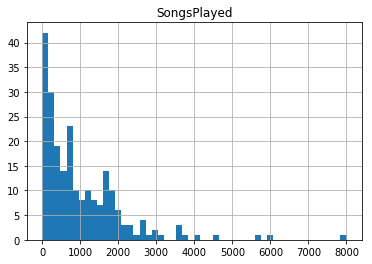

In [20]:
## 可以看出来取关的人听歌更少（x是听歌数量，y是出现次数）
pd_songs.groupby(['cancel']).hist(bins=50);

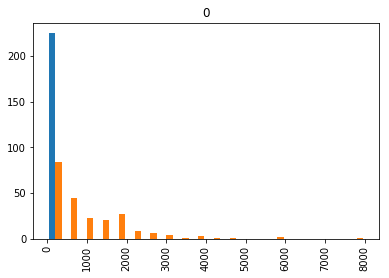

In [21]:
# 加个 by 可以按照 cancel False 和 True 画图（左和右）
## 图形颜色是把出现类别做多的画为不同颜色，和分类无关（想了好半天才想通）
pd_songs.hist(by='cancel',bins=20);

### // length statistic

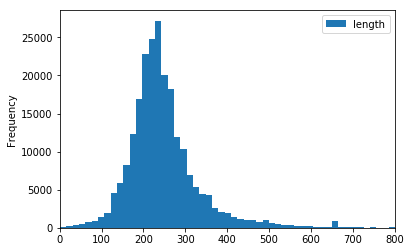

In [22]:
# idea form LK
pd_length = df_clean.select('length').toPandas()
pd_length.plot.hist(bins=200,xlim=(0,800));
## 终于对 xlim 下手了
## 注意由于 pandas 库的历史原因 DataFrame.hist 不支持xlim参数
## DataFrame.plot.hist 就可以

### // gender divided thumps-up/down stats

In [23]:
# gender divided thumps-up/down stats
pd_up = df_clean.where(df_clean.page=='Thumbs Up') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('cancel').toPandas()
pd_down = df_clean.where(df_clean.page=='Thumbs Down') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('cancel').toPandas()

print('ThumbsUps for people who stay',
      pd_up[pd_up['cancel']==False]['ThumbsUps'].mean())
print('ThumbsUps for people who leave',
      pd_up[pd_up['cancel']==True]['ThumbsUps'].mean())
print('ThumbsDowns for people who stay',
      pd_down[pd_down['cancel']==False]['ThumbsDowns'].mean())
print('ThumbsDowns for people who leave',
      pd_down[pd_down['cancel']==True]['ThumbsDowns'].mean())

ThumbsUps for people who stay 57.05
ThumbsUps for people who leave nan
ThumbsDowns for people who stay 12.541871921182265
ThumbsDowns for people who leave nan


In [24]:
pd_up.columns

Index(['cancel', 'userId', 'ThumbsUps'], dtype='object')

In [25]:
pd_up['cancel'].value_counts()

0    220
Name: cancel, dtype: int64

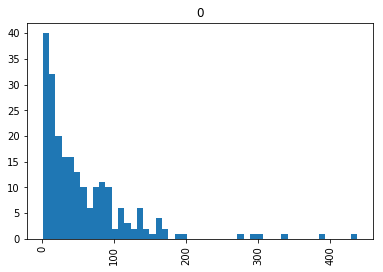

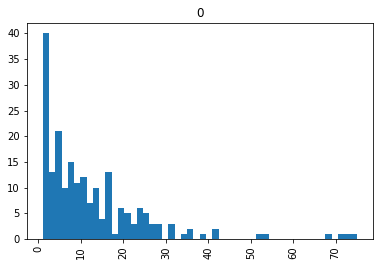

In [26]:
## visulize
pd_up.hist('ThumbsUps', by='cancel', bins=50, sharex=True, sharey=True);
pd_down.hist('ThumbsDowns', by='cancel', bins=50, sharex=True, sharey=True);

## sharex,sharey 是标记x和y的坐标相同，便于对比
## 尝试使用了下 .post.hist 限制x，结果 by 处报错，再研究
## 如果加上了 density=1 就是进行密度转换，后续研究

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

- Numeric Feature
- Category Feature

## / Numeric Feature

In [87]:
# feature - total played items
# feature - total played times
# feature - total played seesions
total_played_items_by_user = df_clean.groupBy('userId').agg(countDistinct('itemInSession').alias('number_of_played_songs'))
total_played_time_by_user = df_clean.groupBy('userId').agg(sum('length').alias('total_play_time'))
total_played_sessions_by_user = df_clean.groupBy('userId').agg(countDistinct('sessionId').alias('number_of_sessions'))

In [88]:
# user df (temp)
user_df = df_clean.select('cancel', 'userId')
user_df = user_df.dropDuplicates()

In [89]:
# numeric df
df_numeric = user_df.join(total_played_items_by_user, ['userId'], how= 'left').\
                            join(total_played_time_by_user, ['userId'], how='left').\
                            join(total_played_sessions_by_user, ['userId'], how='left')

In [90]:
# drop duplicate 'cancel' state
df_numeric = df_numeric.sort(desc('cancel'))
df_numeric = df_numeric.dropDuplicates(subset=['userId'])

In [27]:
# arc ts
## feature played songs
##会发生错误的方法
##检查点 where，groupby 和 groupBy
'''
df_songs = df_clean.where(df_clean.song!='null').groupby('userId') \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])
    
df_songs.show(10),df_songs.dtypes
'''

In [38]:
# check
df_numeric.printSchema(),df_numeric.head(1),df_numeric.show(1)

root
 |-- userId: string (nullable = true)
 |-- cancel: integer (nullable = false)
 |-- SongsPlayed: long (nullable = true)
 |-- ThumbsUps: long (nullable = true)
 |-- ThumbsDowns: long (nullable = true)
 |-- SingersListened: long (nullable = true)
 |-- TotalTime: double (nullable = true)

+------+------+-----------+---------+-----------+---------------+-----------------+
|userId|cancel|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|        TotalTime|
+------+------+-----------+---------+-----------+---------------+-----------------+
|    78|     0|        254|       11|          3|            226|62494.42194000002|
+------+------+-----------+---------+-----------+---------------+-----------------+
only showing top 1 row



(None,
 [Row(userId='78', cancel=0, SongsPlayed=254, ThumbsUps=11, ThumbsDowns=3, SingersListened=226, TotalTime=62494.42194000002)],
 None)

## / Category Feature

In [40]:
# create category df
df_category = df_clean.select('userId', 'gender', 'level', 'location') 

In [41]:
# arc ts
#df_category.show(5),df_category.dtypes

In [42]:
# create new columns
#split location into two new columns, location and country
df_category = df_category.withColumn('location_list', split(df['location'], ','))
df_category = df_category.withColumn('location', df_category.location_list[0])
df_category = df_category.withColumn('country', df_category.location_list[1]).drop('location_list')

In [44]:
# category to numeric
## set category list
category_list = ['gender', 'level', 'location', 'country']

## run loop
##use stringIndexer
for f in category_list:
    stringIndexer = StringIndexer(inputCol=f, outputCol=f + "Index")
    model = stringIndexer.fit(df_category)
    df_category = model.transform(df_category)

In [45]:
# drop original categorical features
##'*' 就是求补集
df_category = df_category.drop(*category_list)

In [47]:
# check
df_category.printSchema(),df_category.head(1),df_category.show(1),df_category.count()

root
 |-- userId: string (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- levelIndex: double (nullable = false)
 |-- locationIndex: double (nullable = false)
 |-- countryIndex: double (nullable = false)

+------+-----------+----------+-------------+------------+
|userId|genderIndex|levelIndex|locationIndex|countryIndex|
+------+-----------+----------+-------------+------------+
|    78|        0.0|       1.0|         91.0|         2.0|
+------+-----------+----------+-------------+------------+
only showing top 1 row



(None,
 [Row(userId='78', genderIndex=0.0, levelIndex=1.0, locationIndex=91.0, countryIndex=2.0)],
 None,
 278154)

## / Final Data

In [81]:
# join features
df_final = df_numeric.join(df_category, ['userId'], how= 'left')
# drop userId
df_final = df_final.drop('userId')

In [92]:
# arc check
#df_final.printSchema(),df_final.head(1),df_final.show(1),df_final.count()

root
 |-- cancel: integer (nullable = false)
 |-- number_of_played_songs: long (nullable = true)
 |-- total_play_time: double (nullable = true)
 |-- number_of_sessions: long (nullable = true)
 |-- genderIndex: double (nullable = true)
 |-- levelIndex: double (nullable = true)
 |-- locationIndex: double (nullable = true)
 |-- countryIndex: double (nullable = true)

+------+----------------------+-----------------+------------------+-----------+----------+-------------+------------+
|cancel|number_of_played_songs|  total_play_time|number_of_sessions|genderIndex|levelIndex|locationIndex|countryIndex|
+------+----------------------+-----------------+------------------+-----------+----------+-------------+------------+
|     1|                   158|94008.87593999998|                 6|        1.0|       0.0|          8.0|        13.0|
+------+----------------------+-----------------+------------------+-----------+----------+-------------+------------+
only showing top 1 row



(None,
 [Row(cancel=1, number_of_played_songs=158, total_play_time=94008.87593999998, number_of_sessions=6, genderIndex=1.0, levelIndex=0.0, locationIndex=8.0, countryIndex=13.0)],
 None,
 278154)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## / Copy Data (df_final->df)

In [93]:
# copy final data
#spark存为文件再读取会快很多
#但发现会改变数据格式，后续研究
df = df_final

In [51]:
# check
df.printSchema(),df.head(1),df.show(1),df.count()

In [94]:
# get feature_lists
feature_list = df.drop('cancel').columns
feature_list
##下面的方法也可以
#feature_list = df.columns
#feature_list.remove('cancel')

['number_of_played_songs',
 'total_play_time',
 'number_of_sessions',
 'genderIndex',
 'levelIndex',
 'locationIndex',
 'countryIndex']

## / Vector Data

In [95]:
# vector
## assembler 
assembler = VectorAssembler(inputCols=feature_list,outputCol='assembler')
#assembler = VectorAssembler(inputCols=feature_cols,outputCol='assembler')
## run (not run if use pipeline)
sample = assembler.transform(df)
#sample = assembler.transform(final_df)

# !!! lazy !!!
## 特别慢！这里 show|head、 在mac 和windows很慢,原因是 spark 的 lazy 机制
## 前面的各种 .methord 在这里才执行，所以很慢
## 在上一节增加持久化的工作就可解决（spark有没有别的方法？）

In [96]:
# vector
## assembler 
#assembler = VectorAssembler(inputCols=feature_list,outputCol='assembler')
assembler = VectorAssembler(inputCols=feature_cols,outputCol='assembler')
## run (not run if use pipeline)
#sample = assembler.transform(df)
sample = assembler.transform(final_df)

# !!! lazy !!!
## 特别慢！这里 show|head、 在mac 和windows很慢,原因是 spark 的 lazy 机制
## 前面的各种 .methord 在这里才执行，所以很慢
## 在上一节增加持久化的工作就可解决（spark有没有别的方法？）

In [97]:
sample.dtypes

[('cancel', 'int'),
 ('number_of_played_songs', 'bigint'),
 ('total_play_time', 'double'),
 ('number_of_sessions', 'bigint'),
 ('genderIndex', 'double'),
 ('levelIndex', 'double'),
 ('locationIndex', 'double'),
 ('countryIndex', 'double'),
 ('assembler', 'vector')]

In [98]:
## scaler
scaler = StandardScaler(inputCol="assembler",
                        outputCol="scaler")
## run (not run if use pipeline)
sample = scaler.fit(sample).transform(sample)

In [99]:
# check transform
## sample 多出两个 vector 就对了
df.dtypes,sample.dtypes

([('cancel', 'int'),
  ('number_of_played_songs', 'bigint'),
  ('total_play_time', 'double'),
  ('number_of_sessions', 'bigint'),
  ('genderIndex', 'double'),
  ('levelIndex', 'double'),
  ('locationIndex', 'double'),
  ('countryIndex', 'double')],
 [('cancel', 'int'),
  ('number_of_played_songs', 'bigint'),
  ('total_play_time', 'double'),
  ('number_of_sessions', 'bigint'),
  ('genderIndex', 'double'),
  ('levelIndex', 'double'),
  ('locationIndex', 'double'),
  ('countryIndex', 'double'),
  ('assembler', 'vector'),
  ('scaler', 'vector')])

## / Split Data 

In [100]:
# data split
train, test = sample.randomSplit([0.8, 0.2],seed=42)

In [101]:
train.dtypes,test.dtypes

([('cancel', 'int'),
  ('number_of_played_songs', 'bigint'),
  ('total_play_time', 'double'),
  ('number_of_sessions', 'bigint'),
  ('genderIndex', 'double'),
  ('levelIndex', 'double'),
  ('locationIndex', 'double'),
  ('countryIndex', 'double'),
  ('assembler', 'vector'),
  ('scaler', 'vector')],
 [('cancel', 'int'),
  ('number_of_played_songs', 'bigint'),
  ('total_play_time', 'double'),
  ('number_of_sessions', 'bigint'),
  ('genderIndex', 'double'),
  ('levelIndex', 'double'),
  ('locationIndex', 'double'),
  ('countryIndex', 'double'),
  ('assembler', 'vector'),
  ('scaler', 'vector')])

## / Algorithm

### // logistic regression

In [102]:
#train
algor_lr = LogisticRegression(labelCol = 'cancel',
                              featuresCol = 'scaler')
model_lr = algor_lr.fit(train)

#predict
predict_train_lr = model_lr.transform(train)
predict_test_lr = model_lr.transform(test)

#evaluate
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='cancel')

print("AUC (The area under ROC for train set) is {}".format(evaluator.evaluate(predict_train_lr)))
print("AUC (The area under ROC for test set) is {}".format(evaluator.evaluate(predict_test_lr)))

AUC (The area under ROC for train set) is 0.9416371158392435
AUC (The area under ROC for test set) is 0.8571428571428572


In [103]:
# summary
trainingSummary = model_lr.summary

## Obtain the objective per iteration
##趋于0.25263839后续研究(objectivehistory的输出是那个数据？)
##比较多注释掉
'''objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)
'''

## Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print(trainingSummary.roc.show())
##可以看出TPR在稳步上升

print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
##还有一个areaUnderAccuracy貌似也是越接近1越好，但为什么前面加个areaUder，需要后续研究
#print("areaUnderAccuracy: " + str(trainingSummary.accuracy))

# Set the model threshold to maximize F-Measure
#如果使用pipeline的话可以将最优模型设置回模型变量中
'''
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
algor_lr.setThreshold(bestThreshold)
''';

+---+---+
|FPR|TPR|
+---+---+
+---+---+
only showing top 0 rows

None
areaUnderROC: 0.9416371158392435


### // logistic regression (binomial)

In [104]:
#train
algor_blr = LogisticRegression(labelCol = 'cancel',
                              featuresCol = 'scaler',
                              family="multinomial")
model_blr = algor_lr.fit(train)

#predict
predict_train_blr = model_blr.transform(train)
predict_test_blr = model_blr.transform(test)

#evaluate
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='cancel')

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_blr)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_blr)))

##结果和lr相同，看来二项分类不用指定family属性（可能自己会选择）
##后续研究默认参数

The area under ROC for train set is 0.9416371158392435
The area under ROC for test set is 0.8571428571428572


### // random forest

In [105]:
#Train the model with RF
algor_rf = RandomForestClassifier(labelCol='cancel',
                                  featuresCol='scaler')
model_rf = algor_rf.fit(train)

In [106]:
#predictions
predict_train_rf = model_rf.transform(train)
predict_test_rf = model_rf.transform(test)

In [107]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_rf)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_rf)))

The area under ROC for train set is 0.9948286052009456
The area under ROC for test set is 0.8465608465608466


### // decision tree

In [108]:
#Train the model with DT
algor_dt = DecisionTreeClassifier(labelCol='cancel',
                                  featuresCol='scaler')
model_dt = algor_dt.fit(train)

In [109]:
#predictions
predict_train_dt = model_dt.transform(train)
predict_test_dt = model_dt.transform(test)

In [110]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_dt)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_dt)))

The area under ROC for train set is 0.8244680851063829
The area under ROC for test set is 0.8968253968253967


### // gbt

In [111]:
#Train the model with DT
algor_gbt = DecisionTreeClassifier(labelCol='cancel',
                                  featuresCol='scaler')
model_gbt = algor_gbt.fit(train)

#predictions
predict_train_gbt = model_gbt.transform(train)
predict_test_gbt = model_gbt.transform(test)

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_gbt)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_gbt)))

The area under ROC for train set is 0.8244680851063829
The area under ROC for test set is 0.8968253968253967


In [121]:
# result iterations
display('--- lr iteration ---', model_lr.summary.totalIterations)
display('--- lrb iteration ---', model_blr.summary.totalIterations)
#display('--- dt iteration ---', model_dt.summary.totalIterations)
#display('--- gbt iteration ---', model_gbt.summary.totalIterations)

'--- lr iteration ---'

35

'--- lrb iteration ---'

35

## optimize (later)
### undersampling

In [122]:
# undersampling
## use sampleBy,but shoud done before trans of data
## http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sampleBy
#stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
#stratified_train.groupby("label").count().show()
# later;

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [123]:
# /Plus/ AWS EMR note (next submit);